In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(2)


In [2]:
def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [3]:
#path = "D:/SML Dataset/"
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_iter = 1000 
#n_trainSamples = [100,250,500,750,1000,1250,1500]
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [4]:
X_train = load_cls(path+"X_train_tokens.p")[:trainSamples]
X_val_cls = load_cls(path+"X_val_tokens.p")

y_train = load_cls(path+"y_train.p")[:trainSamples]
y_val = load_cls(path+"y_val.p")

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

def my_preprocessor(doc):
    return doc

# tokenize the doc and lemmatize its tokens
def my_tokenizer(doc):
    return doc

custom_vec = CountVectorizer(preprocessor=my_preprocessor, tokenizer=my_tokenizer)
cwm = custom_vec.fit_transform(X_train)
tokens = custom_vec.get_feature_names()

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb

In [7]:
feature_pipeline = Pipeline([
('vect',  CountVectorizer(min_df=.0025, max_df=0.25, ngram_range=(1,3),preprocessor=my_preprocessor, tokenizer=my_tokenizer)),
('tfidf', TfidfTransformer()),
])

In [8]:
X_train_f = feature_pipeline.fit_transform(X_train)
X_val_f =feature_pipeline.transform(X_val_cls)

In [9]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [100,150],
    'learning_rate': [0.05,0.1,0.15]
}

In [10]:
clf = GridSearchCV(lgb.LGBMClassifier(boosting_type='gbdt', objective='binary',  min_child_weight=0.001, min_child_samples=20, colsample_bytree=1.0, n_jobs=-1, importance_type='split'), 
                      parameters,n_jobs=-1, verbose=4, iid=True, cv=5)

In [11]:
model = clf.fit(X_train_f, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  2.7min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  3.8min remaining:   25.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.9min finished


In [12]:
model.best_score_

0.6428933333333333

In [13]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'learning_rate': 0.05, 'n_estimators': 150}
learning_rate: 0.05
n_estimators: 150


In [14]:
pickle.dump(model,open("LGBMClassifier_tokens_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [15]:
X_test = load_cls(path+"X_test_tokens.p")
y_test = load_cls(path+"y_test.p")

In [16]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators=model.best_params_['n_estimators'], 
                                   learning_rate=model.best_params_['learning_rate'], objective='binary',  
                                   min_child_weight=0.001, min_child_samples=20, colsample_bytree=1.0, n_jobs=-1, 
                                   silent=True, importance_type='split')

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    X_train_f = feature_pipeline.fit_transform(X_train[:eachTrain])
    bestModel.fit(X_train_f,y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    X_val_f = feature_pipeline.transform(X_val_cls)
    preds_val = bestModel.predict(X_val_f)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    X_test_f = feature_pipeline.transform(X_test)
    preds_test = bestModel.predict(X_test_f)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_f)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)

SampleSize: 100
Train Time:0.46 sec
Validation Accuracy: 49.01%
Validation Time:2.22 sec
Test Accuracy: 48.32%
Test Time:2.19 sec
(0.3866490620490612, 0.126, 0.434)
MRR: 0.3866490620490612
MRR Time:0.51 sec
SampleSize: 500
Train Time:0.34 sec
Validation Accuracy: 49.64%
Validation Time:2.22 sec
Test Accuracy: 49.81%
Test Time:2.23 sec
(0.3879741702741698, 0.13666666666666666, 0.488)
MRR: 0.3879741702741698
MRR Time:0.52 sec
SampleSize: 1000
Train Time:0.70 sec
Validation Accuracy: 50.28%
Validation Time:2.25 sec
Test Accuracy: 49.99%
Test Time:2.24 sec
(0.4129250601250601, 0.168, 0.5066666666666667)
MRR: 0.4129250601250601
MRR Time:0.52 sec
SampleSize: 10000
Train Time:6.22 sec
Validation Accuracy: 56.58%
Validation Time:2.39 sec
Test Accuracy: 55.27%
Test Time:2.40 sec
(0.4923476190476199, 0.25533333333333336, 0.6373333333333333)
MRR: 0.4923476190476199
MRR Time:0.65 sec
SampleSize: 20000
Train Time:10.91 sec
Validation Accuracy: 58.98%
Validation Time:2.36 sec
Test Accuracy: 57.73%
T

In [19]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("LGBMClassifier_Accuracy_tokens.png")
    #plt.show()

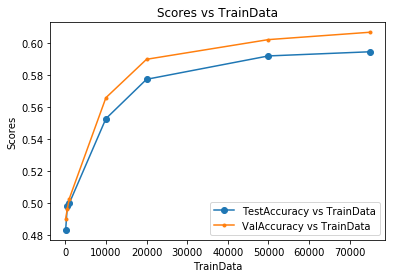

In [20]:
accuracyVisualization()

In [21]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("LGBMClassifier_Mrr_tokens.png")
    plt.show()

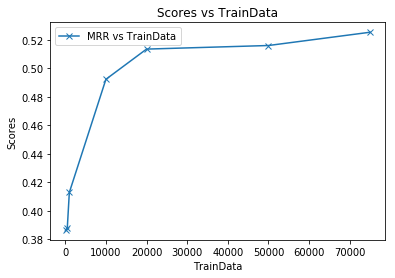

In [22]:
mrrVisualization()

In [23]:
#Precision @1 and Precision @2 Visualizations
def precisionVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precision Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("LGBM_Precision_tokens.png")
    plt.show()

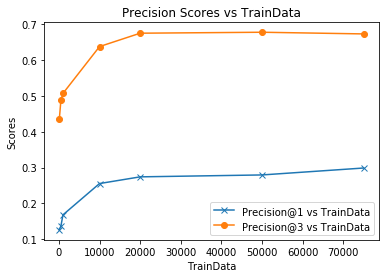

In [24]:
precisionVisualization()